# Streaming Gaussian Mixture Model

## Updating the model when a new object arrives

### General idea

Let $X_1 = \{ x_1, \dotsc, x_N \}$ a collection of $N$ data points generated iid according to a distribution $p(x \mid \Theta)$ given parameter(s) $\Theta$. By Bayes theorem, the _posterior distribution_ of $\Theta$ given $X_1$ is

\begin{equation}
p(\Theta \mid X_1) \propto p(X_1 \mid \Theta)p(\Theta)
\end{equation}

Now, if we want to estimate the posterior of a new collection $X_2 = \{ x_{N+1}, \dotsc, x_{2N} \}$ of data points, the update would be

\begin{align}
p(\Theta \mid X_2, X_1) &\propto p(X_2, X_1 \mid \Theta)p(\Theta) \\
p(\Theta \mid X_2, X_1) &\propto p(X_2 \mid \Theta)p(X_1 \mid \Theta)p(\Theta) \\
p(\Theta \mid X_2, X_1) &\propto p(X_2 \mid \Theta)p(\Theta \mid X_1)
\end{align}

Then, the posterior of collection $b$, after seeing $b - 1$ collection is

\begin{equation}
p(\Theta \mid X_b, \dotsc, X_1) \propto p(X_b \mid \Theta)p(\Theta \mid X_{b-1}, \dotsc, X_1)
\end{equation}.

Following [1], we assume that we approximate the posterior using 
*variational inference*. That is, we assume that we can approximate the posterior of a collection of points with a function $q$, such that

\begin{align}
p(\Theta \mid X_b) \propto q_b(\Theta)
\end{align}

Also, we assume that $p(\Theta)$ is an exponential family distribution for $\Theta$ with sufficients statistic $T(\Theta)$ and natural parameter $\xi_0$. We suppose further that if $q(\Theta)$ is the approximate posterior obtained using variational inference, then $q(\Theta)$ is also in the same exponential family, with natural parameter $\xi$ such that

\begin{equation}
q(\Theta) \propto \text{exp}(\xi \cdot T(\Theta))
\end{equation}

When we make this assumptions, the update for $b$ collections is 

\begin{align}
p(\Theta \mid X_b, \dotsc, X_1) &\propto \left [\prod_{i=1}^B p(X_i \mid \Theta)\right ]p(\Theta) \\ 
p(\Theta \mid X_b, \dotsc, X_1) &\propto \left [\prod_{i=1}^B p(\Theta \mid X_i)p(\Theta)^{-1} \right ]p(\Theta) \\
p(\Theta \mid X_b, \dotsc, X_1) &\approx \left [\prod_{i=1}^B q_i(\Theta)p(\Theta)^{-1} \right ]p(\Theta) \\
p(\Theta \mid X_b, \dotsc, X_1) &\approx \text{exp} \left (\left [\xi_0 + \sum_{i=1}^B (\xi_b - \xi_0) \right ] \cdot T(\Theta) \right) \\
\end{align}.

### Mixture of GMM update

The mean field approximation for the GMM is

\begin{equation}
p(\boldsymbol{\pi}, \boldsymbol{\mu}, \boldsymbol{\Lambda} \mid X) \approx q(\boldsymbol{\pi})q(\boldsymbol{\mu}, \boldsymbol{\Lambda})
\end{equation}

where 

\begin{align}
q(\boldsymbol{\pi}) &= Dir(\boldsymbol{\pi} \mid \boldsymbol{\alpha}) \\
q(\boldsymbol{\mu}, \boldsymbol{\Lambda}) &= \mathcal{N}(\boldsymbol{\mu} \mid \mathbf{m}, (\beta\boldsymbol{\Lambda})^{-1})\mathcal{W}(\boldsymbol{\Lambda} \mid \mathbf{W}, \nu)
\end{align}

#### Dirichlet update

The natural parameter for the dirichlet is:

\begin{equation}
\xi = \boldsymbol{\alpha}_k - 1
\end{equation}

hence, the update is:

\begin{equation}
\boldsymbol{\alpha}_k' \leftarrow \boldsymbol{\alpha}_k + (\boldsymbol{\alpha}_k^{\star} - \boldsymbol{\alpha}_0)
\end{equation}

#### Normal-Wishart update

The natural parameter for the Normal-Wishart distribution is:

\begin{equation}
\xi = \begin{bmatrix}
       \beta_k\boldsymbol{m}_k           \\[0.3em]
       \beta_k \\[0.3em]
       \boldsymbol{W}_k^{-1} + \beta\boldsymbol{m}_k\boldsymbol{m}_k^T \\[0.3em]
       \nu_k + 2 + p
     \end{bmatrix}
\end{equation},

hence, the updates are:

\begin{align}
\beta_k' &\leftarrow \beta_k + (\beta_k^{\star} - \beta_0) \\
\boldsymbol{m}_k' &\leftarrow \frac{1}{\beta_k'}(\beta_k\boldsymbol{m}_k + (\beta_k^{\star}\boldsymbol{m}_k^{\star} - \beta_0\boldsymbol{m}_0) \\
\boldsymbol{W}_k^{-1} &\leftarrow (\boldsymbol{W}_k^{-1} + \beta_k\boldsymbol{m}_k\boldsymbol{m}_k^T) + (\boldsymbol{W}_k^{-1\star} + \beta_k^{\star}\boldsymbol{m}_k^{\star}\boldsymbol{m}_k^{T\star}) - \beta_k\boldsymbol{m}_k\boldsymbol{m}_k^T \\
\nu_k' &\leftarrow \nu_k + (\nu_k^{\star} - \nu_0) \\
\end{align}


## Current problems

* Component identification

## References

[1]: Tamara Broderick, Nicholas Boyd, Andre Wibisono, Ashia C. Wilson, and Michael I. Jordan. 2013. Streaming variational bayes. In Proceedings of the 26th International Conference on Neural Information Processing Systems (NIPS'13), C. J. C. Burges, L. Bottou, M. Welling, Z. Ghahramani, and K. Q. Weinberger (Eds.). Curran Associates Inc., , USA, 1727-1735.

## Synthetic data generation

In the cell below we are going to generate synthetic data from multiple GMMs (one GMM per class).

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import invwishart
import seaborn as sns
import matplotlib.pyplot as plt
import scipy

import logging
logging.basicConfig(level=logging.DEBUG)

logger = logging.getLogger(__name__)

%matplotlib inline
%load_ext autoreload
%autoreload 2

np.random.seed(732839717)

sns.set(rc={"figure.figsize": (6, 6)})

CLASS_COLORS = ['#66c2a5',
                '#fc8d62',
                '#8da0cb',
                '#e78ac3',
                '#a6d854',
                '#ffd92f',
                '#e5c494',
                '#b3b3b3']

/home/lukas/universidad/magister/streaming-bayesian/.env/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
class GMMDataGenerator:
     
    def __init__(self, m, k, d, mu_interval=(-10, 10), mu_var=(-4, 4),
                 cov_var=(-1, 1), gamma_0=3.0, alpha_0=5.0):
        """
        Args:
            k (int): number of components per class.
            d (int): dimension of data.
        """
        self.k = k
        self.d = d
        self._mu_0 = np.zeros(d)
        self.gamma_0 = gamma_0
        self.alpha_0 = alpha_0
        self.mu_interval = mu_interval
        self.mu_var = mu_var
        self.cov_var = cov_var
        self.mu = np.zeros((k, d))
        self.cov = np.zeros((k, d, d))
        self.sample_cov()
        self.sample_mean()
        self.weights = np.random.dirichlet(self.gamma_0 * np.ones(k))
        
    def generate(self, n=2000):
        X = np.zeros((n, self.d))
        Z = np.zeros(n)
        
        # generate the component distributions
        self.pi = np.random.dirichlet(self.alpha_0 * np.ones(self.k))
        for i in range(n):
            # generate random component of this observation
            z_i = np.argmax(np.random.multinomial(1, self.pi))
            Z[i] = z_i
             
            # generate the features
            X[i, :] = np.random.multivariate_normal(self.mu[z_i, :], 
                                                         self.cov[z_i, :])
        return X, Z.astype(int)
    
    def sample_cov(self):
        for j in range(self.k): 
            self.cov[j, :] = invwishart.rvs(2 * self.d, np.eye(self.d))
    
    def sample_from_component(self, k):
        return np.random.multivariate_normal(self.mu[k, :], 
                                             self.cov[k, :])
     
    def get_mu(self):
        return self.mu
    
    def get_cov(self):
        return self.cov
    
    def sample_mean(self):
        a, b = self.mu_interval
        std_min, std_max = self.cov_var
        mu_center = (b - a) * np.random.random(size=self.d) + a
        mu_max = mu_center + self.mu_var[1]
        mu_min = mu_center + self.mu_var[0]
        for j in range(self.k):
            mu_center_k = ((mu_max - mu_min) 
                           * np.random.random(size=self.d)
                           + mu_min)
            self.mu[j, :] = np.random.multivariate_normal(
                self._mu_0 + mu_center_k, self.cov[j, :])

In [3]:
def plot_gmm_obs(X, C, title='', ax=None):
    xlabel = 'x'
    ylabel = 'y'
    components = np.max(C) + 1
    for k in range(components):
        obs_of_k_component = np.where(C == k)[0]
        if ax:
            ax.scatter(X[obs_of_k_component, 0], X[obs_of_k_component, 1], 
                    facecolor=CLASS_COLORS[k], alpha=0.5,
                    edgecolor='black', linewidth=0.15)
        else:
            plt.scatter(X[obs_of_k_component, 0], X[obs_of_k_component, 1], 
                    facecolor=CLASS_COLORS[k], alpha=0.5,
                    edgecolor='black', linewidth=0.15)
    if ax:
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
    else:
        plt.title(title)
        #plt.legend()
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)


In [4]:
pal = sns.light_palette((200, 75, 60), input="husl", as_cmap=True)

def plot_gmm(X, mu, W, ax=None):
    assert mu.shape[0] == W.shape[0]
    dims = mu.shape[0]
    
    if ax:
        ax.scatter(X[:, 0], X[:, 1], 
                    alpha=0.5,
                    edgecolor='black', linewidth=0.15)
    else:
        plt.scatter(X[:, 0], X[:, 1], 
                    alpha=0.5,
                    edgecolor='black', linewidth=0.15)
    min_x, min_y = np.amin(X, axis=0)
    max_x, max_y = np.amax(X, axis=0)
    x, y = np.mgrid[min_x:max_x:0.1, min_y:max_y:0.1]
    z = np.zeros(x.shape + (2,))
    z[:, :, 0] = x;
    z[:, :, 1] = y
    for i in range(mu.shape[0]):
        f_z = scipy.stats.multivariate_normal.pdf(z, mu[i, :], W[i, :])
        if ax:
            ax.contour(x, y, f_z, antialiased=True, cmap=pal)
        else:
            plt.contour(x, y, f_z, antialiased=True, cmap=pal)

In [5]:
M = 1

# Number of components per class.
K = 3

# Dimension of data.
D = 2

#np.random.seed()

synthetic_gmm = GMMDataGenerator(m=M, k=K, d=D)
print('Mu:\n', synthetic_gmm.get_mu())
print('Cov:\n', synthetic_gmm.get_cov())

Mu:
 [[-13.4976689   -9.15391219]
 [ -8.52296015 -10.78440209]
 [ -8.01447974 -11.79393004]]
Cov:
 [[[ 0.87869225 -0.30782368]
  [-0.30782368  0.63133224]]

 [[ 2.1120209   0.36474583]
  [ 0.36474583  0.28096147]]

 [[ 0.8424209   0.99595504]
  [ 0.99595504  1.65430142]]]


# New data batch generation

In the following cell we generate batches of the synthetic GMM.

In [6]:
n_batchs = 10

X_batchs = []
C_batchs = []
for i in range(n_batchs):
    new_X, new_C = synthetic_gmm.generate(n=1000)
    X_batchs.append(new_X)
    C_batchs.append(new_C)

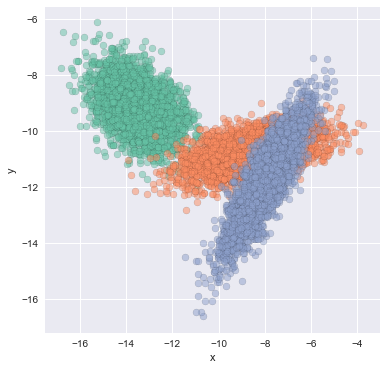

In [7]:
plot_gmm_obs(np.concatenate(X_batchs), np.concatenate(C_batchs))

In the cell bellow we can see the data generated in each batch.

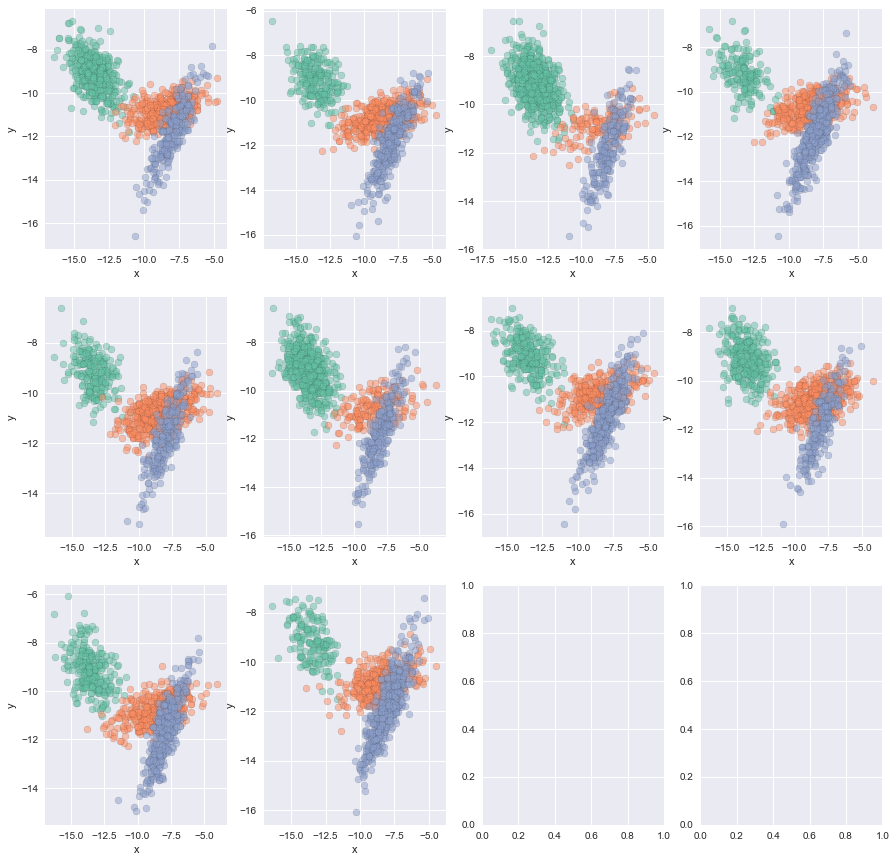

In [8]:
cols = 4
rows = n_batchs // cols + 1
f, ax = plt.subplots(rows, cols, figsize=(15, 15))
for i in range(rows):
    for j in range(cols):
        index = i * cols + j
        if index < n_batchs:
            plot_gmm_obs(X_batchs[index], 
                         C_batchs[index], 
                         ax=ax[i, j])
            #plot_gmm_obs(X_batchs[index], C_batchs[index], ax=ax[i, j])
plt.show()

In [9]:
import json

from streaming_gmm.streaming_variational_gmm import StreamingVariationalGMM, VariationalGMM

#prior =
#W_0 = 5 * np.eye(D)

result_list = []
debug_dict = {}
#streaming_vb_gmm = VariationalGMM(K, D)
for i in range(1, n_batchs + 1):
    logger.info('Starting batch %d', i)
    #X = np.concatenate(X_batchs[:i])
    X = X_batchs[i-1]
    #streaming_vb_gmm.update_with_new_data(X)
    vbGmm = VariationalGMM(K, D, alpha_0=.01)
    vbGmm.fit(X, max_iter=50)
    #batch_result = streaming_vb_gmm.get_checkpoint()
    result_list.append(vbGmm.get_checkpoint())
#plot_gmm(X, vbGmm.m_k, np.linalg.inv(vbGmm.nu_k[:, np.newaxis, np.newaxis]*vbGmm.W_k))


debug_dict = {'checkpoints': []}
for result in result_list:
    new_dict = {}
    for k, v in result['variational_parameters'].items():
        new_dict[k] = np.array_str(v) 
    new_dict['pi_k_expec'] = np.array_str(result['pi_k_expectation'])
    debug_dict['checkpoints'].append(new_dict)

with open('logs/variational_gmm_results.json', 'w') as outfile:
    json.dump(debug_dict, outfile)

INFO:__main__:Starting batch 1
INFO:streaming_gmm.variational_gmm:Start fitting GMM in data
INFO:streaming_gmm.variational_gmm:Iteration: 0
INFO:streaming_gmm.variational_gmm:ELBO: -4187.663663
INFO:streaming_gmm.variational_gmm:Iteration: 5
INFO:streaming_gmm.variational_gmm:ELBO: -4147.689768
INFO:streaming_gmm.variational_gmm:Iteration: 10
INFO:streaming_gmm.variational_gmm:ELBO: -3869.617327
INFO:streaming_gmm.variational_gmm:Iteration: 15
INFO:streaming_gmm.variational_gmm:ELBO: -3687.261435
INFO:streaming_gmm.variational_gmm:Iteration: 20
INFO:streaming_gmm.variational_gmm:ELBO: -3609.479842
INFO:streaming_gmm.variational_gmm:Iteration: 25
INFO:streaming_gmm.variational_gmm:ELBO: -3558.117824
INFO:streaming_gmm.variational_gmm:Iteration: 30
INFO:streaming_gmm.variational_gmm:ELBO: -3528.506122
INFO:streaming_gmm.variational_gmm:Iteration: 35
INFO:streaming_gmm.variational_gmm:ELBO: -3521.964941
INFO:streaming_gmm.variational_gmm:Iteration: 40
INFO:streaming_gmm.variational_gmm:EL

INFO:streaming_gmm.variational_gmm:Iteration: 30
INFO:streaming_gmm.variational_gmm:ELBO: -3406.565037
INFO:streaming_gmm.variational_gmm:Iteration: 35
INFO:streaming_gmm.variational_gmm:ELBO: -3406.565794
INFO:streaming_gmm.variational_gmm:Iteration: 40
INFO:streaming_gmm.variational_gmm:ELBO: -3406.565922
INFO:streaming_gmm.variational_gmm:Finished inference. Elapsed time: 0 secs
DEBUG:streaming_gmm.variational_gmm:Variational mu:
[[-13.42913164  -9.15691348]
 [ -8.44167263 -10.7078704 ]
 [ -8.0411407  -11.85998339]]
DEBUG:streaming_gmm.variational_gmm:Variational W_k:
[[[ 0.00860148  0.00372716]
  [ 0.00372716  0.0117926 ]]

 [[ 0.00146257 -0.00176061]
  [-0.00176061  0.01006929]]

 [[ 0.01086332 -0.00658143]
  [-0.00658143  0.00524229]]]
INFO:__main__:Starting batch 5
INFO:streaming_gmm.variational_gmm:Start fitting GMM in data
INFO:streaming_gmm.variational_gmm:Iteration: 0
INFO:streaming_gmm.variational_gmm:ELBO: -3985.276832
INFO:streaming_gmm.variational_gmm:Iteration: 5
INFO:s

INFO:streaming_gmm.variational_gmm:Iteration: 40
INFO:streaming_gmm.variational_gmm:ELBO: -3467.089349
INFO:streaming_gmm.variational_gmm:Iteration: 45
INFO:streaming_gmm.variational_gmm:ELBO: -3467.090246
INFO:streaming_gmm.variational_gmm:Finished inference. Elapsed time: 0 secs
DEBUG:streaming_gmm.variational_gmm:Variational mu:
[[-13.55506155  -9.07883168]
 [ -8.47931299 -10.7802125 ]
 [ -8.02777468 -11.85734117]]
DEBUG:streaming_gmm.variational_gmm:Variational W_k:
[[[ 0.0050235   0.00279662]
  [ 0.00279662  0.00811402]]

 [[ 0.00173732 -0.0020503 ]
  [-0.0020503   0.01130764]]

 [[ 0.01302686 -0.00763976]
  [-0.00763976  0.00598211]]]
INFO:__main__:Starting batch 8
INFO:streaming_gmm.variational_gmm:Start fitting GMM in data
INFO:streaming_gmm.variational_gmm:Iteration: 0
INFO:streaming_gmm.variational_gmm:ELBO: -4100.102746
INFO:streaming_gmm.variational_gmm:Iteration: 5
INFO:streaming_gmm.variational_gmm:ELBO: -4092.395173
INFO:streaming_gmm.variational_gmm:Iteration: 10
INFO:s

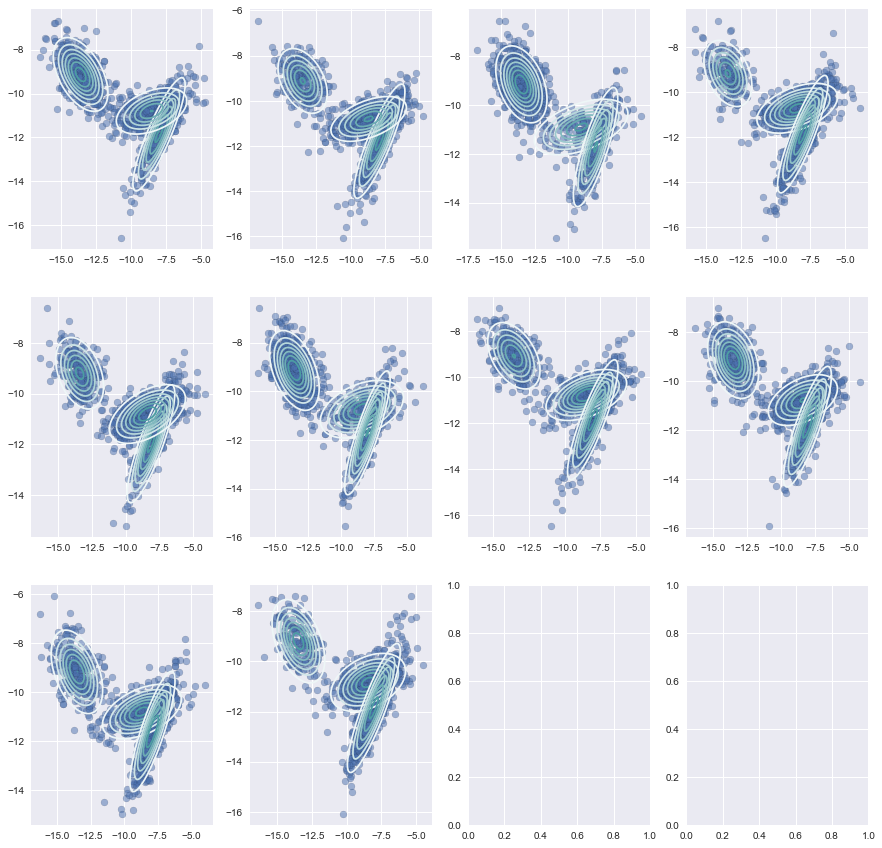

In [10]:
cols = 4
rows = n_batchs // cols + 1
f, ax = plt.subplots(rows, cols, figsize=(15, 15))
for i in range(rows):
    for j in range(cols):
        index = i * cols + j
        if index < n_batchs: 
            #X = np.concatenate(X_batchs[:index + 1])
            X = X_batchs[index]
            C = C_batchs[index]
            variational_params = result_list[index]['variational_parameters']
            m_k = variational_params['m_k']
            nu_k = variational_params['nu_k']
            W_k = variational_params['W_k']
            plot_gmm(X, 
                     m_k, 
                     np.linalg.inv(nu_k[:, np.newaxis, np.newaxis] * W_k),
                     ax=ax[i, j])
plt.show()

In [12]:
from streaming_gmm.streaming_variational_gmm import StreamingVariationalGMM, VariationalGMM

result_list = []
streaming_vb_gmm = StreamingVariationalGMM(K, D, max_iter=50, alpha_0=.01)
for X, C in zip(X_batchs, C_batchs): 
    streaming_vb_gmm.update_with_new_data(X)
    #vbGmm = VariationalGMM(K, D)
    #vbGmm.fit(X, max_iter=20)
    #batch_result = streaming_vb_gmm.get_checkpoint()
    #result_list.append(streaming_vb_gmm.get_checkpoint())
result_list = streaming_vb_gmm.checkpoints
#plot_gmm(X, vbGmm.m_k, np.linalg.inv(vbGmm.nu_k[:, np.newaxis, np.newaxis]*vbGmm.W_k))

INFO:streaming_gmm.variational_gmm:Start fitting GMM in data
INFO:streaming_gmm.variational_gmm:Iteration: 0
INFO:streaming_gmm.variational_gmm:ELBO: -4187.666362
INFO:streaming_gmm.variational_gmm:Iteration: 5
INFO:streaming_gmm.variational_gmm:ELBO: -4146.864372
INFO:streaming_gmm.variational_gmm:Iteration: 10
INFO:streaming_gmm.variational_gmm:ELBO: -3885.649441
INFO:streaming_gmm.variational_gmm:Iteration: 15
INFO:streaming_gmm.variational_gmm:ELBO: -3689.586214
INFO:streaming_gmm.variational_gmm:Iteration: 20
INFO:streaming_gmm.variational_gmm:ELBO: -3611.622810
INFO:streaming_gmm.variational_gmm:Iteration: 25
INFO:streaming_gmm.variational_gmm:ELBO: -3560.678880
INFO:streaming_gmm.variational_gmm:Iteration: 30
INFO:streaming_gmm.variational_gmm:ELBO: -3529.269036
INFO:streaming_gmm.variational_gmm:Iteration: 35
INFO:streaming_gmm.variational_gmm:ELBO: -3522.075542
INFO:streaming_gmm.variational_gmm:Iteration: 40
INFO:streaming_gmm.variational_gmm:ELBO: -3521.155287
INFO:streaming

DEBUG:streaming_gmm.streaming_variational_gmm:identify_components - not iden:
[[-13.50881067  -9.12467732]
 [ -9.52931803 -10.92451255]
 [ -7.92264849 -11.6397097 ]]
DEBUG:streaming_gmm.streaming_variational_gmm:map_from_k_to_list: {0: [(1, 0.59337792804426548), (2, 1.2969053587974331), (0, 4.8774722775989572)], 1: [(2, 0.13811400530095497), (1, 1.8020674307147706), (0, 6.1656075297962749)], 2: [(0, 0.042162530882396486), (1, 4.4059717586356912), (2, 6.1646318835000278)]}
DEBUG:streaming_gmm.streaming_variational_gmm:Mapped elements: {1: 0, 2: 1, 0: 2}
DEBUG:streaming_gmm.streaming_variational_gmm:correct components: {1: 0, 2: 1, 0: 2}
DEBUG:streaming_gmm.streaming_variational_gmm:alpha_k_old_data_delta:
[ 0.  0.  0.]
DEBUG:streaming_gmm.streaming_variational_gmm:beta_k_old_data_delta:
[ 0.  0.  0.]
DEBUG:streaming_gmm.streaming_variational_gmm:old m_k:
[[ -8.94224777 -10.83822307]
 [ -7.83352154 -11.53420205]
 [-13.55097295  -9.12482401]]
DEBUG:streaming_gmm.streaming_variational_gmm:

INFO:streaming_gmm.variational_gmm:Iteration: 5
INFO:streaming_gmm.variational_gmm:ELBO: -4118.625107
INFO:streaming_gmm.variational_gmm:Iteration: 10
INFO:streaming_gmm.variational_gmm:ELBO: -4058.756838
INFO:streaming_gmm.variational_gmm:Iteration: 15
INFO:streaming_gmm.variational_gmm:ELBO: -3590.368289
INFO:streaming_gmm.variational_gmm:Iteration: 20
INFO:streaming_gmm.variational_gmm:ELBO: -3562.378240
INFO:streaming_gmm.variational_gmm:Iteration: 25
INFO:streaming_gmm.variational_gmm:ELBO: -3549.329235
INFO:streaming_gmm.variational_gmm:Iteration: 30
INFO:streaming_gmm.variational_gmm:ELBO: -3540.683994
INFO:streaming_gmm.variational_gmm:Iteration: 35
INFO:streaming_gmm.variational_gmm:ELBO: -3525.446943
INFO:streaming_gmm.variational_gmm:Iteration: 40
INFO:streaming_gmm.variational_gmm:ELBO: -3487.312175
INFO:streaming_gmm.variational_gmm:Iteration: 45
INFO:streaming_gmm.variational_gmm:ELBO: -3473.849466
INFO:streaming_gmm.variational_gmm:Finished inference. Elapsed time: 0 sec

INFO:streaming_gmm.variational_gmm:Iteration: 0
INFO:streaming_gmm.variational_gmm:ELBO: -4100.234734
INFO:streaming_gmm.variational_gmm:Iteration: 5
INFO:streaming_gmm.variational_gmm:ELBO: -4091.744474
INFO:streaming_gmm.variational_gmm:Iteration: 10
INFO:streaming_gmm.variational_gmm:ELBO: -3809.797092
INFO:streaming_gmm.variational_gmm:Iteration: 15
INFO:streaming_gmm.variational_gmm:ELBO: -3682.266448
INFO:streaming_gmm.variational_gmm:Iteration: 20
INFO:streaming_gmm.variational_gmm:ELBO: -3603.821818
INFO:streaming_gmm.variational_gmm:Iteration: 25
INFO:streaming_gmm.variational_gmm:ELBO: -3590.490573
INFO:streaming_gmm.variational_gmm:Iteration: 30
INFO:streaming_gmm.variational_gmm:ELBO: -3589.146353
INFO:streaming_gmm.variational_gmm:Iteration: 35
INFO:streaming_gmm.variational_gmm:ELBO: -3585.834333
INFO:streaming_gmm.variational_gmm:Iteration: 40
INFO:streaming_gmm.variational_gmm:ELBO: -3574.064868
INFO:streaming_gmm.variational_gmm:Iteration: 45
INFO:streaming_gmm.variati

DEBUG:streaming_gmm.streaming_variational_gmm:identify_components - real_m_k:
[[ -8.74690819 -10.80181639]
 [ -7.89578371 -11.59649378]
 [-13.51686548  -9.13577772]]
DEBUG:streaming_gmm.streaming_variational_gmm:identify_components - not iden:
[[ -8.44625621 -10.83500888]
 [-13.4825368   -9.19384754]
 [ -8.03879258 -11.85716806]]
DEBUG:streaming_gmm.streaming_variational_gmm:map_from_k_to_list: {0: [(0, 0.30247867992532423), (2, 1.2709031661230465), (1, 5.0011740819453419)], 1: [(2, 0.29732577802338167), (0, 0.93961652773234416), (1, 6.0814898688884176)], 2: [(1, 0.067457852406338975), (0, 5.3477532547751609), (2, 6.1168004746172437)]}
DEBUG:streaming_gmm.streaming_variational_gmm:Mapped elements: {0: 0, 2: 1, 1: 2}
DEBUG:streaming_gmm.streaming_variational_gmm:correct components: {0: 0, 2: 1, 1: 2}
DEBUG:streaming_gmm.streaming_variational_gmm:alpha_k_old_data_delta:
[ 0.  0.  0.]
DEBUG:streaming_gmm.streaming_variational_gmm:beta_k_old_data_delta:
[ 0.  0.  0.]
DEBUG:streaming_gmm.st

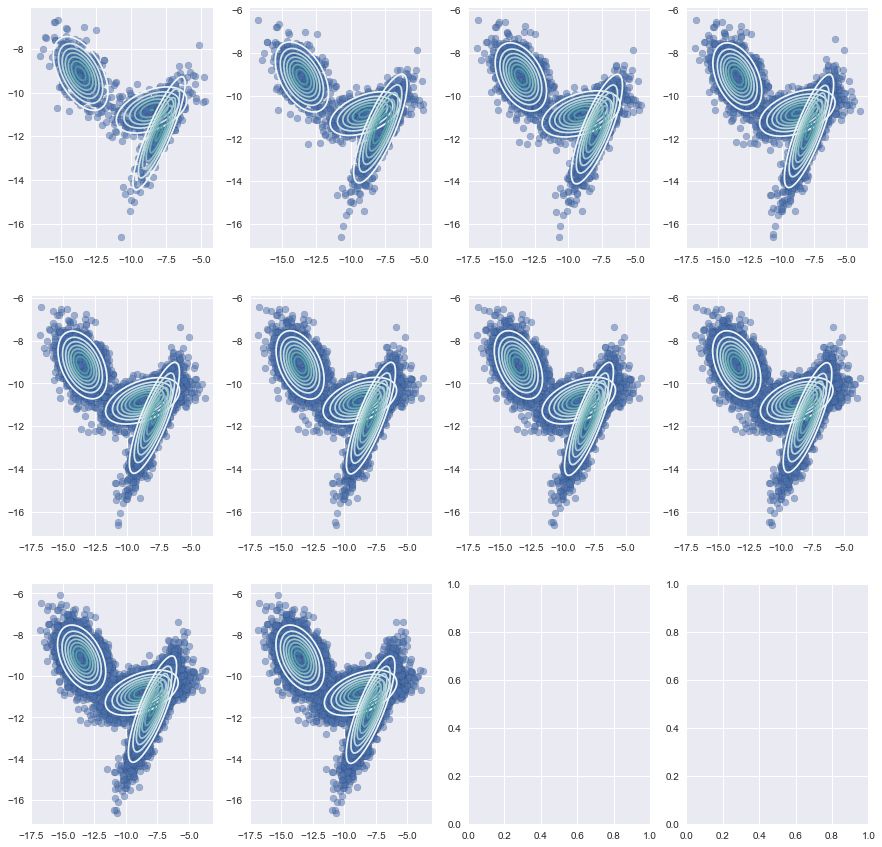

In [13]:
cols = 4
rows = n_batchs // cols + 1
f, ax = plt.subplots(rows, cols, figsize=(15, 15))
for i in range(rows):
    for j in range(cols):
        index = i * cols + j
        if index < n_batchs: 
            X = np.concatenate(X_batchs[:index + 1])
            #X = X_batchs[index]
            C = C_batchs[index]
            variational_params = result_list[index]['streaming_variational_parameters']
            m_k = variational_params['m_k']
            nu_k = variational_params['nu_k']
            W_k = variational_params['W_k']
            plot_gmm(X, 
                     m_k, 
                     np.linalg.inv(nu_k[:, np.newaxis, np.newaxis] * W_k),
                     ax=ax[i, j])
plt.show()
